# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from typing import Tuple
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Image Loader

In [2]:
class ImageDataset(Dataset):
    """Custom dataset for loading images from a directory."""
    
    def __init__(self, image_dir: str, transform=None, image_size: int = 64):
        self.image_dir = image_dir
        self.transform = transform
        self.image_size = image_size
        
        # Get all image files
        self.image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
            self.image_files.extend(glob.glob(os.path.join(image_dir, ext)))
            self.image_files.extend(glob.glob(os.path.join(image_dir, ext.upper())))
        
        if not self.image_files:
            raise ValueError(f"No image files found in {image_dir}")
        
        print(f"Found {len(self.image_files)} images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image

# The Network Class

In [3]:
class VAE(nn.Module):
    def __init__(self, input_channels: int = 3, latent_dim: int = 128, 
                 image_size: int = 64, sparsity_weight: float = 0.001):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.image_size = image_size
        self.sparsity_weight = sparsity_weight  # Weight for L1 sparsity regularization

        self.conv_output_size = 4
        self.conv_output_channels = 512

        # Encoder
        self.encoder = nn.Sequential(
            # 1st conv block: 64x64 -> 32x32, 3 → 64
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        
            # 2nd conv block: 32x32 -> 16x16, 64 → 128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        
            # 3rd conv block: 16x16 -> 8x8, 128 → 256
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        
            # 4th conv block: 8x8 -> 4x4, 256 → 512
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

         # Latent space mapping
        hidden_dim = self.conv_output_channels * self.conv_output_size * self.conv_output_size
        
        # Mean and log variance for the latent distribution
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder input
        self.fc_decode = nn.Linear(latent_dim, hidden_dim)

        # Decoder
        self.decoder = nn.Sequential(
            # First deconv block: 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # Second deconv block: 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # Third deconv block: 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Fourth deconv block: 32x32 -> 64x64
            nn.ConvTranspose2d(64, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output values in [0, 1] range
        )

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Encode input to latent distribution parameters.
        
        Returns:
            mu: Mean of the latent distribution
            logvar: Log variance of the latent distribution
        """
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar
        
    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick: z = mu + std * epsilon
        
        This allows gradients to flow through the sampling process.
        Instead of sampling directly from N(mu, var), we sample epsilon ~ N(0,1)
        and compute z = mu + std * epsilon, where std = exp(0.5 * logvar)
        
        Args:
            mu: Mean of the distribution
            logvar: Log variance of the distribution
            
        Returns:
            z: Sample from the latent distribution
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            epsilon = torch.randn_like(std)
            return mu + std * epsilon
        else:
            # During inference, just return the mean
            return mu
            
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Decode latent sample to reconstruct image.
        
        Args:
            z: Latent sample
            
        Returns:
            Reconstructed image
        """
        x = self.fc_decode(z)
        x = x.view(x.size(0), self.conv_output_channels, 
                   self.conv_output_size, self.conv_output_size)
        x = self.decoder(x)
        return x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass through the VAE.
        
        Returns:
            recon_x: Reconstructed input
            mu: Mean of latent distribution
            logvar: Log variance of latent distribution
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        
        return recon_x, mu, logvar

# Defining the Loss Function

In [4]:
def vae_loss_function(recon_x: torch.Tensor, x: torch.Tensor, 
                     mu: torch.Tensor, logvar: torch.Tensor, 
                     z: torch.Tensor, beta: float = 1.0, 
                     sparsity_weight: float = 0.001) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    VAE loss function with L1 sparsity regularization.
    
    The loss consists of three terms:
    1. Reconstruction Loss: How well the VAE reconstructs the input
    2. KL Divergence: Regularization term encouraging latent distribution to be N(0,1)
    3. Sparsity Loss: L1 regularization on latent representations for sparsity
    
    Args:
        recon_x: Reconstructed input
        x: Original input
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        z: Sampled latent representation
        beta: Weight for KL divergence term (beta-VAE)
        sparsity_weight: Weight for L1 sparsity regularization
        
    Returns:
        total_loss: Combined loss
        recon_loss: Reconstruction loss component
        kl_loss: KL divergence component
        sparsity_loss: L1 sparsity loss component
    """
    
    # Reconstruction loss (Binary Cross Entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # L1 Sparsity regularization on latent representations
    # Encourages many latent dimensions to be close to zero
    sparsity_loss = torch.sum(torch.abs(z))
    
    # Total loss with beta weighting for KL and sparsity weighting for L1
    total_loss = recon_loss + beta * kl_loss + sparsity_weight * sparsity_loss
    
    return total_loss, recon_loss, kl_loss, sparsity_loss


# The Trainer

In [5]:
class VAETrainer:
    """
    Trainer class for the Sparse VAE with utilities for training, evaluation, and generation.
    """
    
    def __init__(self, model: VAE, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.sparsity_losses = []
        
    def train_epoch(self, dataloader: DataLoader, optimizer: optim.Optimizer, 
                   beta: float = 1.0, sparsity_weight: float = 0.001) -> float:
        """
        Train the Sparse VAE for one epoch.
        
        Args:
            dataloader: Training data loader
            optimizer: Optimizer
            beta: Beta parameter for beta-VAE (controls KL weight)
            sparsity_weight: Weight for L1 sparsity regularization
            
        Returns:
            Average loss for the epoch
        """
        self.model.train()
        total_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0
        total_sparsity_loss = 0
        
        for batch_idx, data in enumerate(dataloader):
            data = data.to(self.device)
            optimizer.zero_grad()
            
            # Forward pass
            recon_batch, mu, logvar = self.model(data)
            
            # Get latent sample for sparsity regularization
            z = self.model.reparameterize(mu, logvar)
            
            # Compute loss with sparsity regularization
            loss, recon_loss, kl_loss, sparsity_loss = vae_loss_function(
                recon_batch, data, mu, logvar, z, beta, sparsity_weight
            )
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            total_sparsity_loss += sparsity_loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, '
                      f'Recon: {recon_loss.item():.4f}, KL: {kl_loss.item():.4f}, '
                      f'Sparsity: {sparsity_loss.item():.4f}')
        
        avg_loss = total_loss / len(dataloader.dataset)
        avg_recon = total_recon_loss / len(dataloader.dataset)
        avg_kl = total_kl_loss / len(dataloader.dataset)
        avg_sparsity = total_sparsity_loss / len(dataloader.dataset)
        
        print(f'Epoch Summary - Total: {avg_loss:.4f}, Recon: {avg_recon:.4f}, '
              f'KL: {avg_kl:.4f}, Sparsity: {avg_sparsity:.4f}')
        
        self.sparsity_losses.append(avg_sparsity)
        return avg_loss
    
    def validate(self, dataloader: DataLoader, beta: float = 1.0, 
                sparsity_weight: float = 0.001) -> float:
        """Validate the Sparse VAE on validation data."""
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for data in dataloader:
                data = data.to(self.device)
                recon_batch, mu, logvar = self.model(data)
                z = self.model.reparameterize(mu, logvar)
                loss, _, _, _ = vae_loss_function(
                    recon_batch, data, mu, logvar, z, beta, sparsity_weight
                )
                total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader.dataset)
        return avg_loss
    
    def generate_samples(self, num_samples: int = 16) -> torch.Tensor:
        """
        Generate new samples by sampling from the prior distribution N(0,I).
        
        This demonstrates the generative capability of VAEs.
        """
        self.model.eval()
        
        with torch.no_grad():
            # Sample from standard normal distribution
            z = torch.randn(num_samples, self.model.latent_dim).to(self.device)
            
            # Decode to generate images
            samples = self.model.decode(z)
            
        return samples
    
    def reconstruct_images(self, dataloader: DataLoader, num_images: int = 8) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Reconstruct images from the dataset to visualize reconstruction quality.
        """
        self.model.eval()
        
        with torch.no_grad():
            data = next(iter(dataloader))[:num_images].to(self.device)
            recon_data, _, _ = self.model(data)
            
        return data, recon_data
    
    def interpolate_latent_space(self, dataloader: DataLoader, steps: int = 10) -> torch.Tensor:
        """
        Interpolate between two points in latent space to show smooth transitions.
        This demonstrates the continuity of the learned latent space.
        """
        self.model.eval()
        
        with torch.no_grad():
            # Get two random images
            data = next(iter(dataloader))[:2].to(self.device)
            
            # Encode to get latent representations
            mu1, _ = self.model.encode(data[0:1])
            mu2, _ = self.model.encode(data[1:2])
            
            # Create interpolation steps
            alphas = torch.linspace(0, 1, steps).to(self.device)
            interpolations = []
            
            for alpha in alphas:
                # Linear interpolation in latent space
                z_interp = (1 - alpha) * mu1 + alpha * mu2
                
                # Decode interpolated latent vector
                decoded = self.model.decode(z_interp)
                interpolations.append(decoded)
            
            # Concatenate all interpolations
            interpolated_images = torch.cat(interpolations, dim=0)
            
        return interpolated_images
    
    def analyze_sparsity(self, dataloader: DataLoader, max_samples: int = 1000):
        """
        Analyze the sparsity of learned latent representations.
        Shows distribution of latent activations and sparsity statistics.
        """
        self.model.eval()
        latent_vectors = []
        
        with torch.no_grad():
            sample_count = 0
            for data in dataloader:
                if sample_count >= max_samples:
                    break
                    
                data = data.to(self.device)
                mu, logvar = self.model.encode(data)
                z = self.model.reparameterize(mu, logvar)
                latent_vectors.append(z.cpu().numpy())
                sample_count += data.size(0)
        
        # Concatenate all latent vectors
        latent_vectors = np.concatenate(latent_vectors, axis=0)[:max_samples]
        
        # Calculate sparsity statistics
        sparsity_threshold = 0.1  # Consider values below this as "sparse"
        sparsity_ratios = np.mean(np.abs(latent_vectors) < sparsity_threshold, axis=0)
        overall_sparsity = np.mean(sparsity_ratios)
        
        print(f"\n=== Sparsity Analysis ===")
        print(f"Overall sparsity ratio: {overall_sparsity:.3f}")
        print(f"Dimensions with >90% sparsity: {np.sum(sparsity_ratios > 0.9)}/{len(sparsity_ratios)}")
        print(f"Dimensions with >50% sparsity: {np.sum(sparsity_ratios > 0.5)}/{len(sparsity_ratios)}")
        
        # Plot sparsity analysis
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot 1: Histogram of latent activations
        axes[0, 0].hist(latent_vectors.flatten(), bins=50, alpha=0.7, edgecolor='black')
        axes[0, 0].set_title('Distribution of Latent Activations')
        axes[0, 0].set_xlabel('Activation Value')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero')
        axes[0, 0].legend()
        
        # Plot 2: Sparsity ratio per dimension
        axes[0, 1].bar(range(len(sparsity_ratios)), sparsity_ratios)
        axes[0, 1].set_title('Sparsity Ratio per Latent Dimension')
        axes[0, 1].set_xlabel('Latent Dimension')
        axes[0, 1].set_ylabel('Sparsity Ratio')
        axes[0, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50% threshold')
        axes[0, 1].legend()
        
        # Plot 3: Mean absolute activation per dimension
        mean_abs_activations = np.mean(np.abs(latent_vectors), axis=0)
        axes[1, 0].bar(range(len(mean_abs_activations)), mean_abs_activations)
        axes[1, 0].set_title('Mean Absolute Activation per Dimension')
        axes[1, 0].set_xlabel('Latent Dimension')
        axes[1, 0].set_ylabel('Mean |Activation|')
        
        # Plot 4: Sparsity losses over training
        if self.sparsity_losses:
            axes[1, 1].plot(self.sparsity_losses, label='Sparsity Loss')
            axes[1, 1].set_title('Sparsity Loss Over Training')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('L1 Sparsity Loss')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'No sparsity loss data', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Sparsity Loss Over Training')
        
        plt.tight_layout()
        plt.show()
        
        return latent_vectors, sparsity_ratios
    
    def plot_latent_space_2d(self, dataloader: DataLoader, max_samples: int = 1000):
        """
        Visualize the latent space in 2D (only works if latent_dim >= 2).
        Shows how different images are distributed in the latent space.
        """
        if self.model.latent_dim < 2:
            print("Latent dimension must be at least 2 for 2D visualization")
            return
            
        self.model.eval()
        latent_vectors = []
        
        with torch.no_grad():
            sample_count = 0
            for data in dataloader:
                if sample_count >= max_samples:
                    break
                    
                data = data.to(self.device)
                mu, _ = self.model.encode(data)
                latent_vectors.append(mu.cpu().numpy())
                sample_count += data.size(0)
        
        # Concatenate all latent vectors
        latent_vectors = np.concatenate(latent_vectors, axis=0)[:max_samples]
        
        # Plot first two dimensions
        plt.figure(figsize=(10, 8))
        plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], alpha=0.6, s=1)
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.title('Latent Space Visualization (First 2 Dimensions)')
        plt.grid(True, alpha=0.3)
        plt.show()

# Training

In [6]:
def train_vae(image_dir: str, epochs: int = 100, batch_size: int = 32, 
              learning_rate: float = 1e-3, latent_dim: int = 128, 
              image_size: int = 64, beta: float = 1.0, sparsity_weight: float = 0.001):
    """
    Main training function for the Sparse VAE.
    
    Args:
        image_dir: Directory containing training images
        epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate for Adam optimizer
        latent_dim: Dimensionality of latent space
        image_size: Size to resize images to (square)
        beta: Beta parameter for beta-VAE (1.0 = standard VAE)
        sparsity_weight: Weight for L1 sparsity regularization
    """
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Data transforms
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # Normalize to [0, 1] range - already done by ToTensor for PIL images
    ])
    
    # Dataset and dataloader
    dataset = ImageDataset(image_dir, transform=transform, image_size=image_size)
    
    # Split dataset into train and validation
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    print(f"Dataset size: {len(dataset)}")
    print(f"Training samples: {train_size}, Validation samples: {val_size}")
    
    # Initialize model with sparsity weight
    model = VAE(input_channels=3, latent_dim=latent_dim, 
                image_size=image_size, sparsity_weight=sparsity_weight)
    trainer = VAETrainer(model, device)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                   factor=0.5, patience=10, verbose=True)
    
    # Training loop
    print(f"\nStarting training for {epochs} epochs...")
    print(f"Beta (KL weight): {beta}")
    print(f"Sparsity weight: {sparsity_weight}")
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        
        # Train
        train_loss = trainer.train_epoch(train_loader, optimizer, beta, sparsity_weight)
        trainer.train_losses.append(train_loss)
        
        # Validate
        val_loss = trainer.validate(val_loader, beta, sparsity_weight)
        trainer.val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        print(f'Validation Loss: {val_loss:.4f}')
        
        # Save samples every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Generate new samples
            generated = trainer.generate_samples(16)
            save_image(generated, f'sparse_generated_epoch_{epoch+1}.png', nrow=4, normalize=True)
            
            # Show reconstructions
            orig, recon = trainer.reconstruct_images(val_loader, 8)
            comparison = torch.cat([orig, recon], dim=0)
            save_image(comparison, f'sparse_reconstruction_epoch_{epoch+1}.png', nrow=8, normalize=True)
            
            # Save model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'sparsity_weight': sparsity_weight,
                'beta': beta,
            }, f'sparse_vae_checkpoint_epoch_{epoch+1}.pt')
    
    return trainer


# Visualizaton functions

In [7]:
def show_tensor_images(tensor, nrow=5, title=None):
    """
    Utility to display a batch of images inline in the notebook.
    """
    grid = make_grid(tensor, nrow=nrow, normalize=True)
    np_img = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.imshow(np_img)
    plt.axis("off")
    plt.show()

def explore_latent_space(trainer: VAETrainer, dataloader: DataLoader):
    """
    Explore the learned latent space with various visualizations and analyses.
    Includes sparsity analysis for the sparse autoencoder.
    """
    print("\n=== Exploring Sparse Latent Space ===")
    
    # 1. Generate new samples
    print("Generating new samples...")
    generated = trainer.generate_samples(25)
    show_tensor_images(generated, nrow=5, title="Generated Samples")
    
    # 2. Show reconstructions
    print("Creating reconstruction comparison...")
    orig, recon = trainer.reconstruct_images(dataloader, 10)
    comparison = torch.cat([orig, recon], dim=0)
    show_tensor_images(comparison, nrow=10, title="Original (top) vs Reconstruction (bottom)")
    
    # 3. Latent space interpolation
    print("Creating latent space interpolation...")
    interpolated = trainer.interpolate_latent_space(dataloader, steps=12)
    show_tensor_images(interpolated, nrow=12, title="Latent Space Interpolation")
    
    # 4. Sparsity analysis - NEW FEATURE
    print("Analyzing sparsity patterns...")
    latent_vectors, sparsity_ratios = trainer.analyze_sparsity(dataloader)
    
    # 5. Plot latent space (if 2D or higher)
    print("Visualizing latent space distribution...")
    trainer.plot_latent_space_2d(dataloader)
    
    # 6. Plot training curves including sparsity
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(trainer.train_losses, label='Training Loss')
    plt.plot(trainer.val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(trainer.train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss (Log Scale)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    if trainer.sparsity_losses:
        plt.plot(trainer.sparsity_losses, label='Sparsity Loss', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('L1 Sparsity Loss')
        plt.title('Sparsity Loss Over Training')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No sparsity data', ha='center', va='center')
        plt.title('Sparsity Loss Over Training')
    
    plt.tight_layout()
    plt.show()

# Comparing Sparsity Levels

In [8]:
def compare_sparsity_levels(image_dir: str, sparsity_weights: list = [0.0, 0.001, 0.01, 0.1]):
    """
    Compare different sparsity levels by training multiple models.
    This helps find the optimal sparsity weight.
    """
    print(f"\n=== Comparing Sparsity Levels ===")
    print(f"Testing sparsity weights: {sparsity_weights}")
    
    results = {}
    
    for sparsity_weight in sparsity_weights:
        print(f"\n--- Training with sparsity weight: {sparsity_weight} ---")
        
        # Train model with current sparsity weight (reduced epochs for comparison)
        trainer = train_vae(
            image_dir=image_dir,
            epochs=20,  # Reduced for comparison
            batch_size=32,
            learning_rate=1e-3,
            latent_dim=128,
            image_size=64,
            beta=1.0,
            sparsity_weight=sparsity_weight
        )
        
        # Analyze results
        val_dataset = ImageDataset(image_dir, image_size=64)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
        
        latent_vectors, sparsity_ratios = trainer.analyze_sparsity(val_loader, max_samples=500)
        overall_sparsity = np.mean(sparsity_ratios)
        
        results[sparsity_weight] = {
            'trainer': trainer,
            'overall_sparsity': overall_sparsity,
            'final_loss': trainer.val_losses[-1] if trainer.val_losses else 0
        }
        
        print(f"Final validation loss: {results[sparsity_weight]['final_loss']:.4f}")
        print(f"Overall sparsity: {overall_sparsity:.3f}")
    
    # Plot comparison
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    weights = list(results.keys())
    sparsities = [results[w]['overall_sparsity'] for w in weights]
    plt.bar(range(len(weights)), sparsities)
    plt.xlabel('Sparsity Weight')
    plt.ylabel('Overall Sparsity Ratio')
    plt.title('Sparsity vs Weight')
    plt.xticks(range(len(weights)), [str(w) for w in weights])
    
    plt.subplot(1, 3, 2)
    losses = [results[w]['final_loss'] for w in weights]
    plt.bar(range(len(weights)), losses)
    plt.xlabel('Sparsity Weight')
    plt.ylabel('Final Validation Loss')
    plt.title('Reconstruction Quality vs Sparsity')
    plt.xticks(range(len(weights)), [str(w) for w in weights])
    
    plt.subplot(1, 3, 3)
    plt.scatter(sparsities, losses)
    for i, w in enumerate(weights):
        plt.annotate(f'w={w}', (sparsities[i], losses[i]), xytext=(5, 5), 
                    textcoords='offset points')
    plt.xlabel('Overall Sparsity Ratio')
    plt.ylabel('Final Validation Loss')
    plt.title('Sparsity vs Quality Trade-off')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Start-Up

=== Sparse Variational Autoencoder Training ===
Configuration:
  Image directory: /kaggle/input/fruit-recognition/Apple/Apple A
  Epochs: 100
  Batch size: 32
  Learning rate: 0.001
  Latent dimension: 128
  Image size: 64x64
  Beta: 1.0
  Sparsity weight: 0.001
Using device: cpu
Found 692 images
Dataset size: 692
Training samples: 553, Validation samples: 139

Starting training for 100 epochs...
Beta (KL weight): 1.0
Sparsity weight: 0.001

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Batch 0, Loss: 308410.3438, Recon: 307856.3125, KL: 550.4161, Sparsity: 3612.3804
Epoch Summary - Total: 8662.7563, Recon: 8454.6921, KL: 207.9202, Sparsity: 143.8956
Validation Loss: 15567.2954

Epoch 2/100
Batch 0, Loss: 281966.3438, Recon: 261974.1562, KL: 19981.4824, Sparsity: 10726.6748
Epoch Summary - Total: 8402.0184, Recon: 8046.6251, KL: 355.1515, Sparsity: 241.8548
Validation Loss: 8649.5732

Epoch 3/100
Batch 0, Loss: 260387.3125, Recon: 256611.7812, KL: 3770.7349, Sparsity: 4789.5117
Epoch Summary - Total: 8017.8706, Recon: 7923.9425, KL: 93.7885, Sparsity: 139.6370
Validation Loss: 8027.7399

Epoch 4/100
Batch 0, Loss: 253278.9531, Recon: 251242.8750, KL: 2032.4332, Sparsity: 3636.1509
Epoch Summary - Total: 7857.2921, Recon: 7797.5691, KL: 59.6072, Sparsity: 115.7936
Validation Loss: 7789.8371

Epoch 5/100
Batch 0, Loss: 247904.2500, Recon: 246453.2031, KL: 1447.6948, Sparsity: 3366.7983
Epoch Summary - Total: 7749.8537, Recon: 7694.7490, KL: 54.9923, Sparsity: 112.3389
V

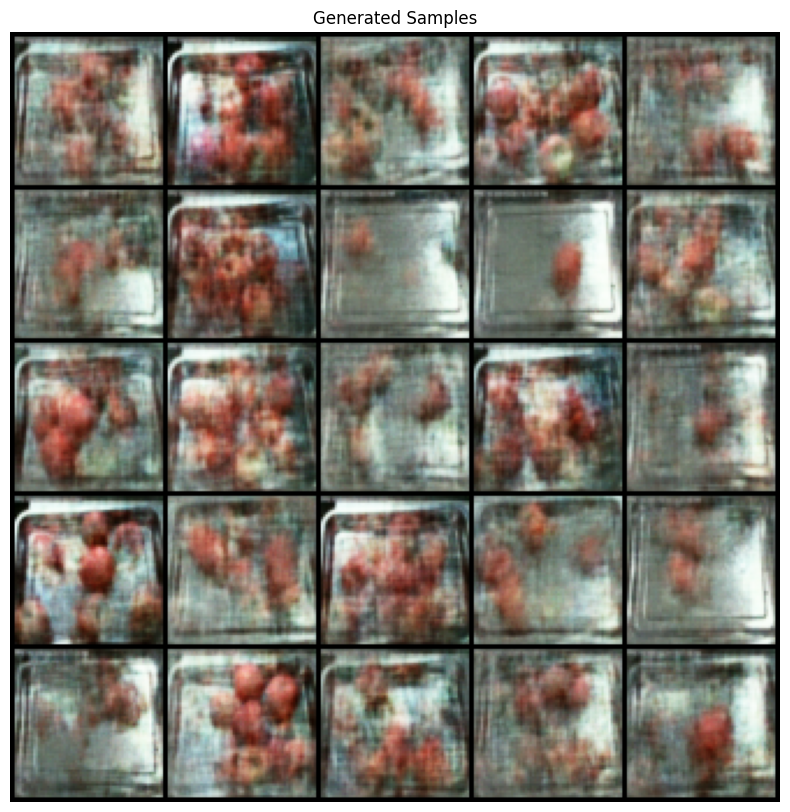

Creating reconstruction comparison...


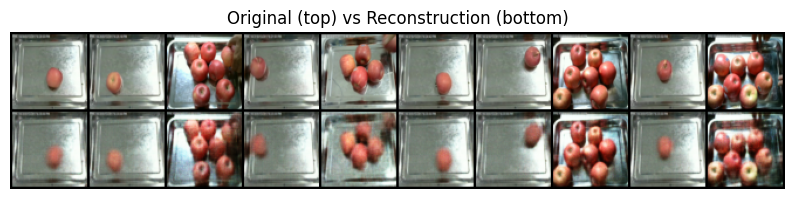

Creating latent space interpolation...


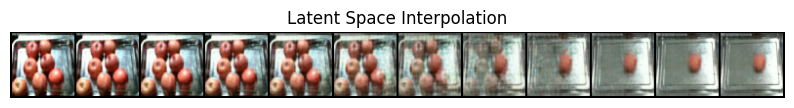

Analyzing sparsity patterns...

=== Sparsity Analysis ===
Overall sparsity ratio: 0.200
Dimensions with >90% sparsity: 0/128
Dimensions with >50% sparsity: 0/128


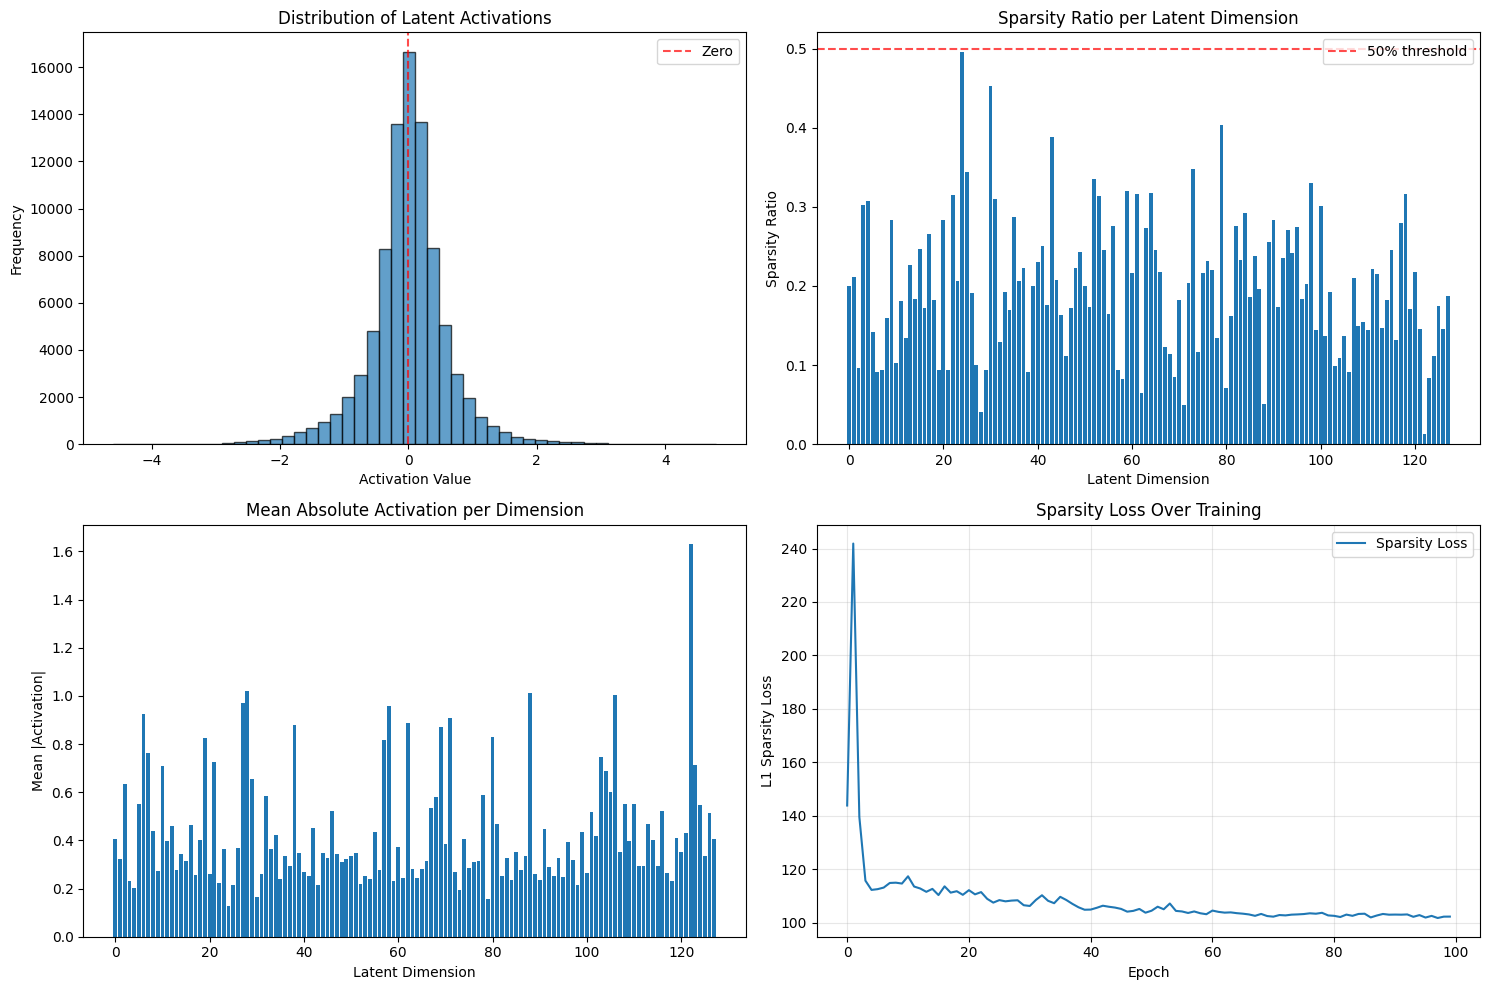

Visualizing latent space distribution...


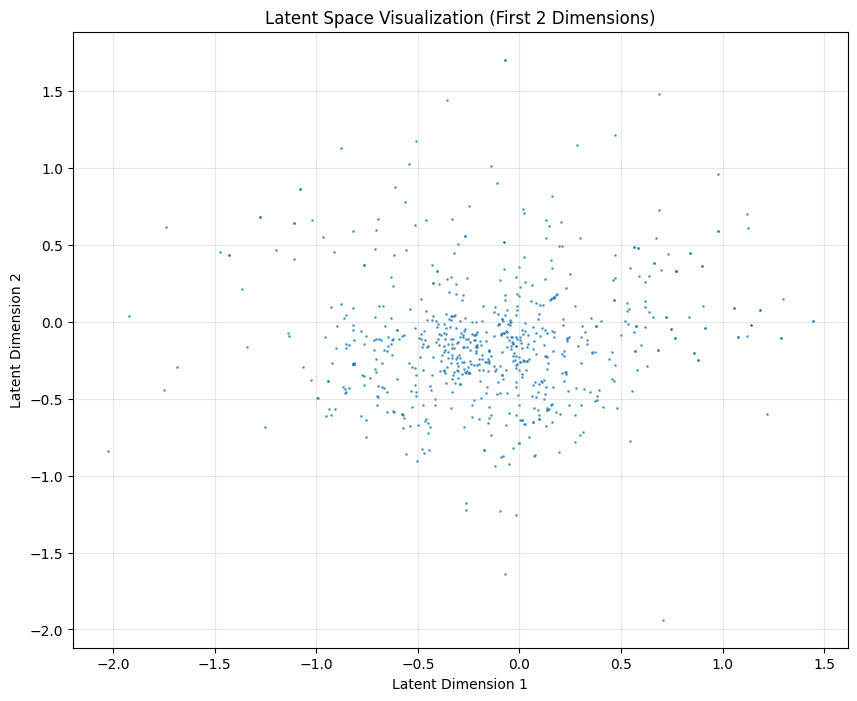

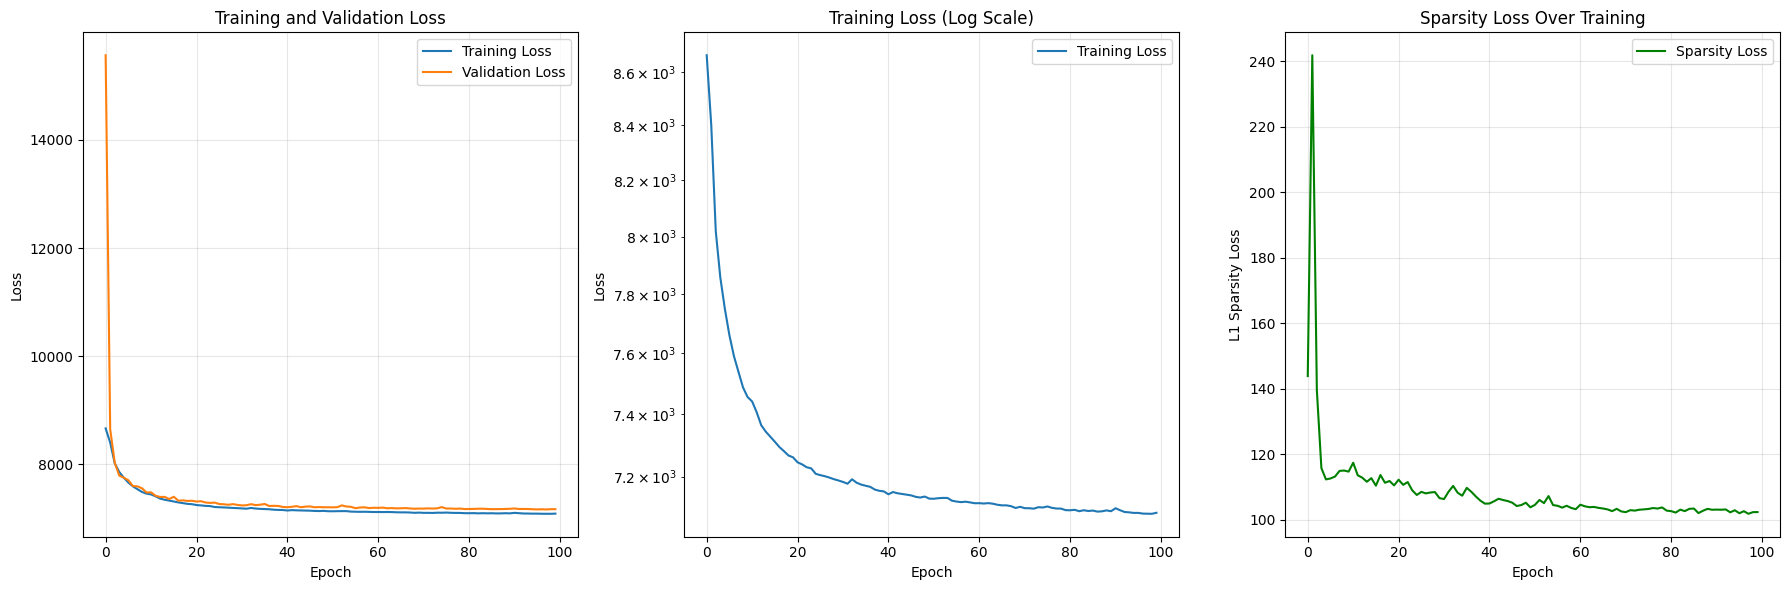


=== Training Complete! ===
Generated files:
  - sparse_generated_epoch_*.png: Generated samples during training
  - sparse_reconstruction_epoch_*.png: Reconstruction comparisons
  - sparse_vae_checkpoint_epoch_*.pt: Model checkpoints

=== Optional: Compare Different Sparsity Levels ===
Uncomment the next line to compare multiple sparsity weights:
# compare_sparsity_levels(IMAGE_DIR, [0.0, 0.001, 0.005, 0.01, 0.05])


In [9]:
if __name__ == "__main__":
    import glob
    
    # Configuration
    IMAGE_DIR = '/kaggle/input/fruit-recognition/Apple/Apple A'
    EPOCHS = 100
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-3
    LATENT_DIM = 128
    IMAGE_SIZE = 64
    BETA = 1.0  # Try different values: 0.5, 1.0, 2.0, 4.0
    SPARSITY_WEIGHT = 0.001  # NEW: L1 sparsity regularization weight
    
    print("=== Sparse Variational Autoencoder Training ===")
    print(f"Configuration:")
    print(f"  Image directory: {IMAGE_DIR}")
    print(f"  Epochs: {EPOCHS}")
    print(f"  Batch size: {BATCH_SIZE}")
    print(f"  Learning rate: {LEARNING_RATE}")
    print(f"  Latent dimension: {LATENT_DIM}")
    print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
    print(f"  Beta: {BETA}")
    print(f"  Sparsity weight: {SPARSITY_WEIGHT}")
    
    # Check if image directory exists
    if not os.path.exists(IMAGE_DIR):
        print(f"\nERROR: Image directory '{IMAGE_DIR}' not found!")
        print("Please update IMAGE_DIR to point to your Kaggle dataset directory.")
        print("\nExample directory structure:")
        print("dataset/")
        print("├── image1.jpg")
        print("├── image2.jpg")
        print("└── ...")
    else:
        # Train the Sparse VAE
        trainer = train_vae(
            image_dir=IMAGE_DIR,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE,
            latent_dim=LATENT_DIM,
            image_size=IMAGE_SIZE,
            beta=BETA,
            sparsity_weight=SPARSITY_WEIGHT
        )
        
        # Explore the learned latent space with sparsity analysis
        transform = transforms.Compose([
                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.ToTensor(),
        ])

        val_dataset = ImageDataset(IMAGE_DIR, transform=transform, image_size=IMAGE_SIZE)
        # val_dataset = ImageDataset(IMAGE_DIR, image_size=IMAGE_SIZE)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
        explore_latent_space(trainer, val_loader)
        
        print("\n=== Training Complete! ===")
        print("Generated files:")
        print("  - sparse_generated_epoch_*.png: Generated samples during training")
        print("  - sparse_reconstruction_epoch_*.png: Reconstruction comparisons")
        print("  - sparse_vae_checkpoint_epoch_*.pt: Model checkpoints")
        
        # Optional: Compare different sparsity levels
        print("\n=== Optional: Compare Different Sparsity Levels ===")
        print("Uncomment the next line to compare multiple sparsity weights:")
        print("# compare_sparsity_levels(IMAGE_DIR, [0.0, 0.001, 0.005, 0.01, 0.05])")